# ICEEMDAN-MKL Visualization

This notebook visualizes the output from `example_finance_csv.cpp`.

**Prerequisites:**
```bash
# Build and run the C++ example first
cmake -B build -DCMAKE_BUILD_TYPE=Release
cmake --build build
./build/example_finance_csv
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

## 1. Load Data

In [2]:
# Load all datasets
datasets = {}

for name in ['garch', 'regime', 'multiscale']:
    datasets[name] = {
        'signal': pd.read_csv(f'{name}_signal.csv'),
        'imfs': pd.read_csv(f'{name}_imfs.csv'),
        'stats': pd.read_csv(f'{name}_imf_stats.csv'),
        'diag': pd.read_csv(f'{name}_diagnostics.csv')
    }
    print(f"Loaded {name}: {len(datasets[name]['imfs'].columns)-2} IMFs")

Loaded garch: 8 IMFs
Loaded regime: 5 IMFs
Loaded multiscale: 6 IMFs


## 2. Helper Functions

In [3]:
def plot_decomposition(signal_df, imfs_df, title="ICEEMDAN Decomposition", max_imfs=8):
    """
    Plot original signal and all IMFs in a stacked layout.
    """
    # Get IMF columns
    imf_cols = [c for c in imfs_df.columns if c.startswith('imf_')]
    n_imfs = min(len(imf_cols), max_imfs)
    
    fig = plt.figure(figsize=(14, 2 + 1.5 * (n_imfs + 2)))
    gs = GridSpec(n_imfs + 2, 1, hspace=0.3)
    
    x = imfs_df['index'].values
    
    # Original signal
    ax0 = fig.add_subplot(gs[0])
    ax0.plot(x, signal_df['price'], 'b-', linewidth=0.8)
    ax0.set_ylabel('Signal')
    ax0.set_title(title, fontsize=14, fontweight='bold')
    ax0.set_xlim([x[0], x[-1]])
    
    # IMFs
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, n_imfs))
    for i, col in enumerate(imf_cols[:n_imfs]):
        ax = fig.add_subplot(gs[i + 1])
        ax.plot(x, imfs_df[col], color=colors[i], linewidth=0.6)
        ax.set_ylabel(f'IMF {i}')
        ax.set_xlim([x[0], x[-1]])
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Residue
    ax_res = fig.add_subplot(gs[-1])
    ax_res.plot(x, imfs_df['residue'], 'r-', linewidth=1)
    ax_res.set_ylabel('Residue')
    ax_res.set_xlabel('Sample Index')
    ax_res.set_xlim([x[0], x[-1]])
    
    plt.tight_layout()
    return fig


def plot_energy_distribution(stats_df, title="Energy Distribution"):
    """
    Bar chart of energy percentage per IMF.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    
    labels = stats_df['imf'].values
    energy_pct = stats_df['energy_pct'].values
    
    colors = ['steelblue'] * (len(labels) - 1) + ['firebrick']  # Residue in red
    bars = ax.bar(range(len(labels)), energy_pct, color=colors, edgecolor='black', linewidth=0.5)
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel('Energy (%)')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylim([0, max(energy_pct) * 1.1])
    
    # Add value labels
    for bar, val in zip(bars, energy_pct):
        if val > 1:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    return fig


def plot_reconstruction(signal_df, imfs_df, title="Reconstruction Verification"):
    """
    Verify that IMFs + residue = original signal.
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
    
    x = imfs_df['index'].values
    original = signal_df['price'].values
    
    # Reconstruct
    imf_cols = [c for c in imfs_df.columns if c.startswith('imf_')]
    reconstructed = imfs_df['residue'].values.copy()
    for col in imf_cols:
        reconstructed += imfs_df[col].values
    
    error = original - reconstructed
    
    # Plot
    axes[0].plot(x, original, 'b-', label='Original', linewidth=1)
    axes[0].plot(x, reconstructed, 'r--', label='Reconstructed', linewidth=1, alpha=0.7)
    axes[0].set_ylabel('Value')
    axes[0].legend(loc='upper right')
    axes[0].set_title(title, fontsize=12, fontweight='bold')
    
    axes[1].plot(x, error, 'g-', linewidth=0.5)
    axes[1].set_ylabel('Error')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_title(f'Reconstruction Error (max: {np.max(np.abs(error)):.2e})', fontsize=10)
    
    plt.tight_layout()
    return fig


def plot_frequency_analysis(imfs_df, title="Frequency Content per IMF"):
    """
    Show power spectrum of each IMF.
    """
    imf_cols = [c for c in imfs_df.columns if c.startswith('imf_')]
    n_imfs = len(imf_cols)
    
    fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(12, 1.5 * (n_imfs + 1)), sharex=True)
    
    n = len(imfs_df)
    freqs = np.fft.rfftfreq(n)
    
    for i, col in enumerate(imf_cols):
        spectrum = np.abs(np.fft.rfft(imfs_df[col].values))
        axes[i].semilogy(freqs, spectrum, linewidth=0.8)
        axes[i].set_ylabel(f'IMF {i}')
        axes[i].set_xlim([0, 0.5])
        
        # Find peak frequency
        peak_idx = np.argmax(spectrum[1:]) + 1  # Skip DC
        axes[i].axvline(x=freqs[peak_idx], color='red', linestyle='--', alpha=0.5)
    
    # Residue
    spectrum = np.abs(np.fft.rfft(imfs_df['residue'].values))
    axes[-1].semilogy(freqs, spectrum, 'r-', linewidth=0.8)
    axes[-1].set_ylabel('Residue')
    axes[-1].set_xlabel('Normalized Frequency')
    axes[-1].set_xlim([0, 0.5])
    
    fig.suptitle(title, fontsize=12, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

## 3. Hilbert-Huang Transform Functions

In [4]:
def compute_instantaneous_freq_amp(imf, fs=1.0):
    """
    Compute instantaneous frequency and amplitude using Hilbert transform.
    
    Parameters:
    -----------
    imf : array-like
        Intrinsic Mode Function
    fs : float
        Sampling frequency (default 1.0 for normalized frequency)
    
    Returns:
    --------
    inst_freq : array
        Instantaneous frequency at each sample
    inst_amp : array
        Instantaneous amplitude (envelope)
    phase : array
        Instantaneous phase
    """
    # Compute analytic signal
    analytic = hilbert(imf)
    
    # Instantaneous amplitude (envelope)
    inst_amp = np.abs(analytic)
    
    # Instantaneous phase
    phase = np.unwrap(np.angle(analytic))
    
    # Instantaneous frequency (derivative of phase)
    inst_freq = np.diff(phase) / (2 * np.pi) * fs
    inst_freq = np.append(inst_freq, inst_freq[-1])  # Pad to match length
    
    # Clean up negative frequencies (shouldn't happen for true IMFs)
    inst_freq = np.abs(inst_freq)
    
    return inst_freq, inst_amp, phase


def compute_hilbert_spectrum(imfs_df, fs=1.0, freq_bins=256, smooth_sigma=1.0):
    """
    Compute Hilbert spectrum (time-frequency energy distribution).
    
    Parameters:
    -----------
    imfs_df : DataFrame
        DataFrame with IMF columns
    fs : float
        Sampling frequency
    freq_bins : int
        Number of frequency bins
    smooth_sigma : float
        Gaussian smoothing sigma
    
    Returns:
    --------
    spectrum : 2D array
        Hilbert spectrum (time x frequency)
    time_axis : array
        Time axis
    freq_axis : array
        Frequency axis
    """
    imf_cols = [c for c in imfs_df.columns if c.startswith('imf_')]
    n = len(imfs_df)
    
    # Frequency range (0 to Nyquist)
    freq_axis = np.linspace(0, fs / 2, freq_bins)
    time_axis = np.arange(n)
    
    # Initialize spectrum
    spectrum = np.zeros((n, freq_bins))
    
    # Accumulate energy from each IMF
    for col in imf_cols:
        imf = imfs_df[col].values
        inst_freq, inst_amp, _ = compute_instantaneous_freq_amp(imf, fs)
        
        # Map frequencies to bins and accumulate energy
        for t in range(n):
            freq = inst_freq[t]
            if 0 <= freq <= fs / 2:
                bin_idx = int(freq / (fs / 2) * (freq_bins - 1))
                bin_idx = min(bin_idx, freq_bins - 1)
                spectrum[t, bin_idx] += inst_amp[t] ** 2  # Energy = amplitude^2
    
    # Smooth for visualization
    if smooth_sigma > 0:
        spectrum = gaussian_filter(spectrum, sigma=smooth_sigma)
    
    return spectrum, time_axis, freq_axis


def compute_marginal_spectrum(spectrum, freq_axis):
    """
    Compute marginal Hilbert spectrum (integrate over time).
    Shows the overall frequency distribution.
    """
    return np.sum(spectrum, axis=0)

In [5]:
def plot_instantaneous_freq_amp(imfs_df, max_imfs=6, title="Instantaneous Frequency & Amplitude"):
    """
    Plot instantaneous frequency and amplitude for each IMF.
    """
    imf_cols = [c for c in imfs_df.columns if c.startswith('imf_')]
    n_imfs = min(len(imf_cols), max_imfs)
    
    fig, axes = plt.subplots(n_imfs, 3, figsize=(15, 2.5 * n_imfs))
    if n_imfs == 1:
        axes = axes.reshape(1, -1)
    
    x = imfs_df['index'].values
    
    for i, col in enumerate(imf_cols[:n_imfs]):
        imf = imfs_df[col].values
        inst_freq, inst_amp, phase = compute_instantaneous_freq_amp(imf)
        
        # IMF with envelope
        axes[i, 0].plot(x, imf, 'b-', linewidth=0.5, alpha=0.7)
        axes[i, 0].plot(x, inst_amp, 'r-', linewidth=1, label='Envelope')
        axes[i, 0].plot(x, -inst_amp, 'r-', linewidth=1)
        axes[i, 0].set_ylabel(f'IMF {i}')
        axes[i, 0].set_xlim([x[0], x[-1]])
        if i == 0:
            axes[i, 0].set_title('IMF & Envelope')
            axes[i, 0].legend(loc='upper right', fontsize=8)
        
        # Instantaneous frequency
        axes[i, 1].plot(x, inst_freq, 'g-', linewidth=0.5)
        axes[i, 1].set_ylabel('Freq')
        axes[i, 1].set_xlim([x[0], x[-1]])
        axes[i, 1].set_ylim([0, min(0.5, np.percentile(inst_freq, 99) * 1.2)])
        if i == 0:
            axes[i, 1].set_title('Instantaneous Frequency')
        
        # Phase
        axes[i, 2].plot(x, phase, 'm-', linewidth=0.5)
        axes[i, 2].set_ylabel('Phase')
        axes[i, 2].set_xlim([x[0], x[-1]])
        if i == 0:
            axes[i, 2].set_title('Instantaneous Phase')
    
    # X labels on bottom row
    for j in range(3):
        axes[-1, j].set_xlabel('Sample Index')
    
    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig


def plot_hilbert_spectrum(imfs_df, fs=1.0, title="Hilbert Spectrum", freq_bins=128):
    """
    Plot Hilbert spectrum (time-frequency representation).
    """
    spectrum, time_axis, freq_axis = compute_hilbert_spectrum(imfs_df, fs=fs, freq_bins=freq_bins)
    marginal = compute_marginal_spectrum(spectrum, freq_axis)
    
    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 3], hspace=0.05, wspace=0.05)
    
    # Main spectrum
    ax_main = fig.add_subplot(gs[1, 0])
    
    # Use log scale for better visualization
    spectrum_plot = spectrum.T
    spectrum_plot[spectrum_plot < 1e-10] = 1e-10  # Avoid log(0)
    
    im = ax_main.pcolormesh(time_axis, freq_axis, spectrum_plot,
                            norm=LogNorm(vmin=spectrum_plot[spectrum_plot > 0].min(),
                                        vmax=spectrum_plot.max()),
                            cmap='viridis', shading='auto')
    ax_main.set_xlabel('Sample Index')
    ax_main.set_ylabel('Normalized Frequency')
    ax_main.set_ylim([0, 0.3])  # Focus on lower frequencies
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax_main, label='Energy (log scale)')
    
    # Top: Original signal
    ax_signal = fig.add_subplot(gs[0, 0], sharex=ax_main)
    
    # Reconstruct signal from IMFs
    imf_cols = [c for c in imfs_df.columns if c.startswith('imf_')]
    signal_approx = imfs_df['residue'].values.copy()
    for col in imf_cols:
        signal_approx += imfs_df[col].values
    
    ax_signal.plot(time_axis, signal_approx, 'b-', linewidth=0.5)
    ax_signal.set_ylabel('Signal')
    ax_signal.set_title(title, fontsize=14, fontweight='bold')
    plt.setp(ax_signal.get_xticklabels(), visible=False)
    
    # Right: Marginal spectrum
    ax_marginal = fig.add_subplot(gs[1, 1], sharey=ax_main)
    ax_marginal.plot(marginal, freq_axis, 'r-', linewidth=1)
    ax_marginal.fill_betweenx(freq_axis, 0, marginal, alpha=0.3, color='red')
    ax_marginal.set_xlabel('Marginal\nSpectrum')
    plt.setp(ax_marginal.get_yticklabels(), visible=False)
    ax_marginal.set_ylim([0, 0.3])
    
    plt.tight_layout()
    return fig


def plot_hilbert_spectrum_3d(imfs_df, fs=1.0, title="3D Hilbert Spectrum", freq_bins=64):
    """
    Plot 3D Hilbert spectrum.
    """
    from mpl_toolkits.mplot3d import Axes3D
    
    spectrum, time_axis, freq_axis = compute_hilbert_spectrum(imfs_df, fs=fs, 
                                                               freq_bins=freq_bins, 
                                                               smooth_sigma=2.0)
    
    # Downsample time for visualization
    downsample = max(1, len(time_axis) // 200)
    time_ds = time_axis[::downsample]
    spectrum_ds = spectrum[::downsample, :]
    
    T, F = np.meshgrid(time_ds, freq_axis)
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Log scale for better visualization
    Z = np.log10(spectrum_ds.T + 1e-10)
    
    surf = ax.plot_surface(T, F, Z, cmap='viridis', alpha=0.8,
                           linewidth=0, antialiased=True)
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Normalized Frequency')
    ax.set_zlabel('log₁₀(Energy)')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylim([0, 0.25])
    ax.view_init(elev=30, azim=45)
    
    fig.colorbar(surf, shrink=0.5, aspect=10, label='log₁₀(Energy)')
    
    plt.tight_layout()
    return fig

## 4. GARCH Price Series (Volatility Clustering)

In [6]:
data = datasets['garch']

# Show diagnostics
print("GARCH Decomposition Diagnostics:")
print(data['diag'].to_string(index=False))

GARCH Decomposition Diagnostics:
             metric       value
      signal_length 2048.000000
           num_imfs    8.000000
         elapsed_ms   37.030000
orthogonality_index    0.633167
           rng_seed   42.000000
          nan_count    0.000000


In [7]:
# Full decomposition view
fig = plot_decomposition(data['signal'], data['imfs'], 
                         title="GARCH Price Series - ICEEMDAN Decomposition")
plt.show()

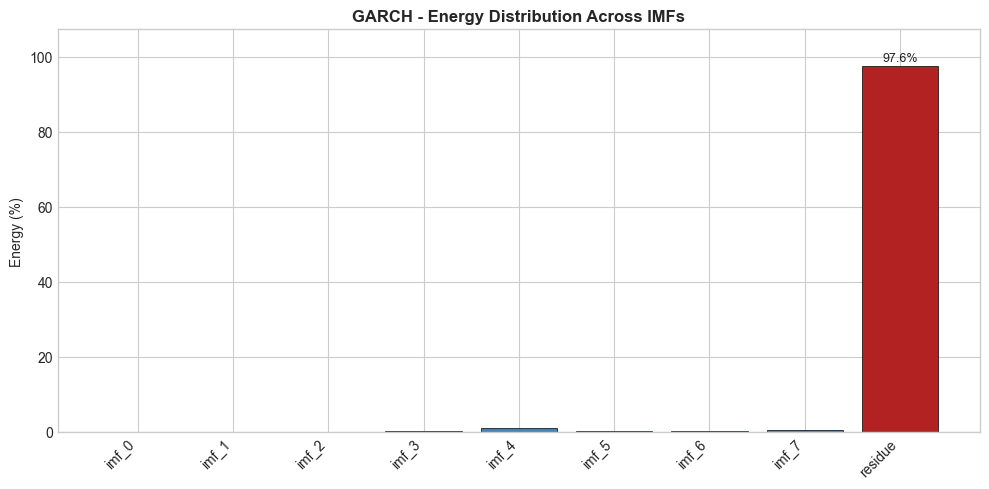

In [8]:
# Energy distribution
fig = plot_energy_distribution(data['stats'], 
                               title="GARCH - Energy Distribution Across IMFs")
plt.show()

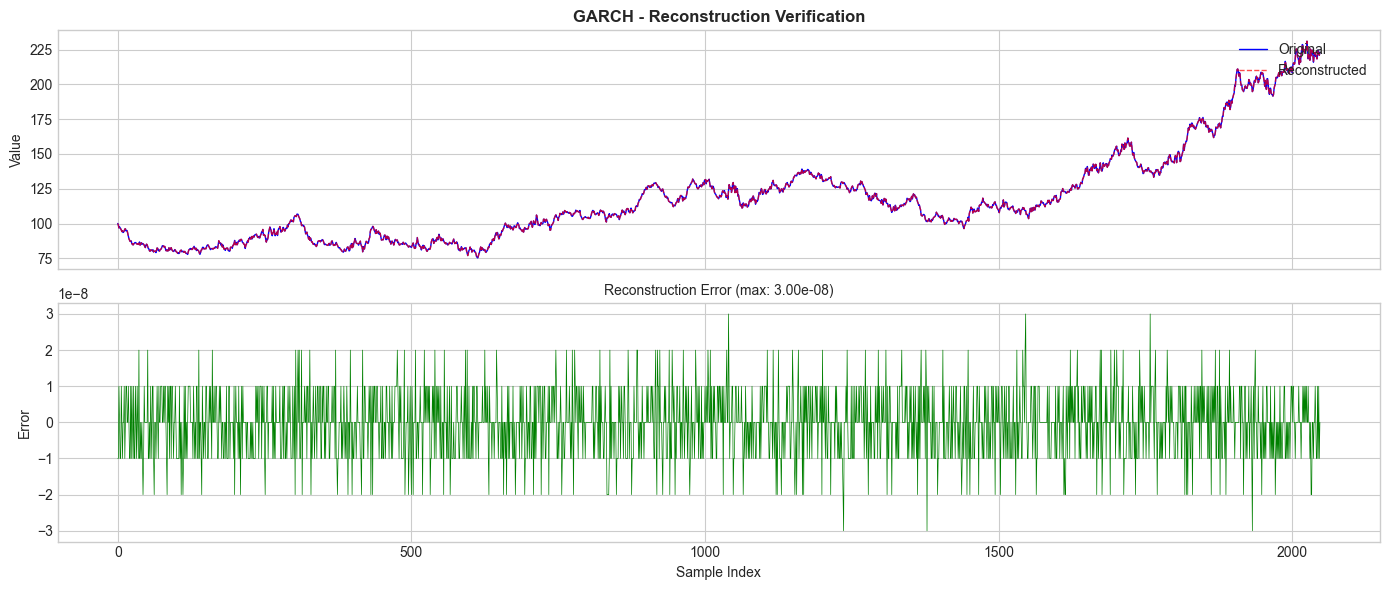

In [9]:
# Reconstruction check
fig = plot_reconstruction(data['signal'], data['imfs'],
                          title="GARCH - Reconstruction Verification")
plt.show()

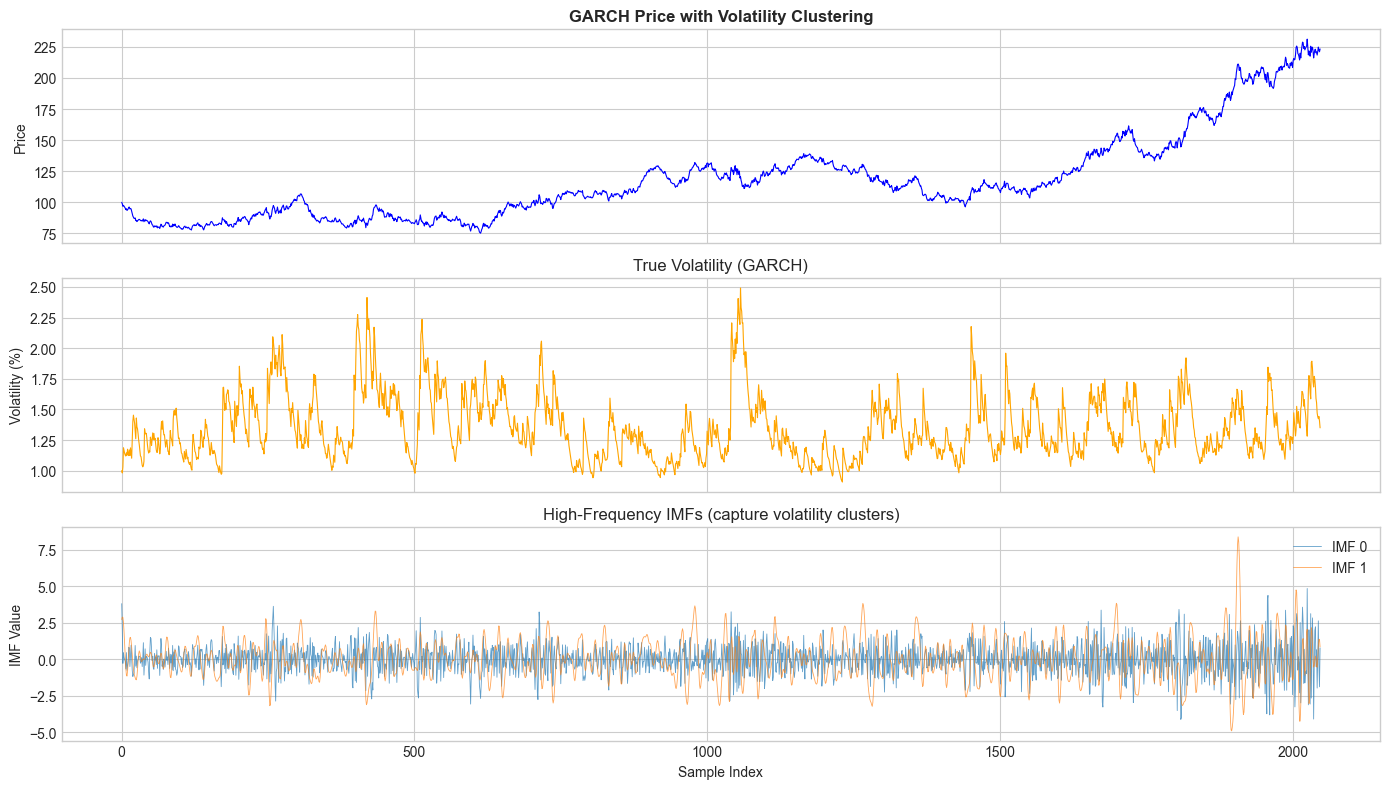

In [10]:
# Signal + underlying volatility
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

x = data['signal']['index']

axes[0].plot(x, data['signal']['price'], 'b-', linewidth=0.8)
axes[0].set_ylabel('Price')
axes[0].set_title('GARCH Price with Volatility Clustering', fontsize=12, fontweight='bold')

axes[1].plot(x, data['signal']['volatility'] * 100, 'orange', linewidth=0.8)
axes[1].set_ylabel('Volatility (%)')
axes[1].set_title('True Volatility (GARCH)')

# Show first few IMFs (high frequency noise)
axes[2].plot(x, data['imfs']['imf_0'], alpha=0.7, linewidth=0.6, label='IMF 0')
axes[2].plot(x, data['imfs']['imf_1'], alpha=0.7, linewidth=0.6, label='IMF 1')
axes[2].set_ylabel('IMF Value')
axes[2].set_xlabel('Sample Index')
axes[2].legend(loc='upper right')
axes[2].set_title('High-Frequency IMFs (capture volatility clusters)')

plt.tight_layout()
plt.show()

### 4.1 Hilbert Analysis - GARCH

In [11]:
# Instantaneous frequency and amplitude
fig = plot_instantaneous_freq_amp(data['imfs'], max_imfs=5,
                                   title="GARCH - Instantaneous Frequency & Amplitude")
plt.show()

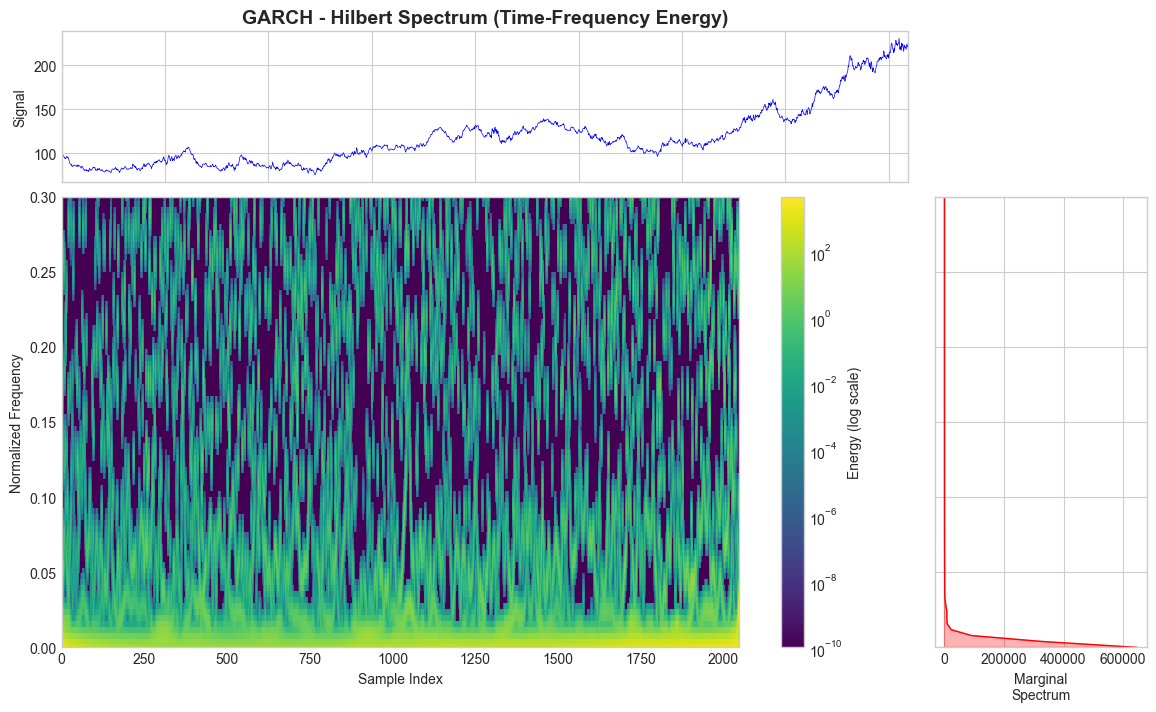

In [12]:
# Hilbert spectrum (2D time-frequency)
fig = plot_hilbert_spectrum(data['imfs'], 
                            title="GARCH - Hilbert Spectrum (Time-Frequency Energy)")
plt.show()

In [13]:
# 3D Hilbert spectrum
fig = plot_hilbert_spectrum_3d(data['imfs'],
                                title="GARCH - 3D Hilbert Spectrum")
plt.show()

## 5. Regime-Switching Signal

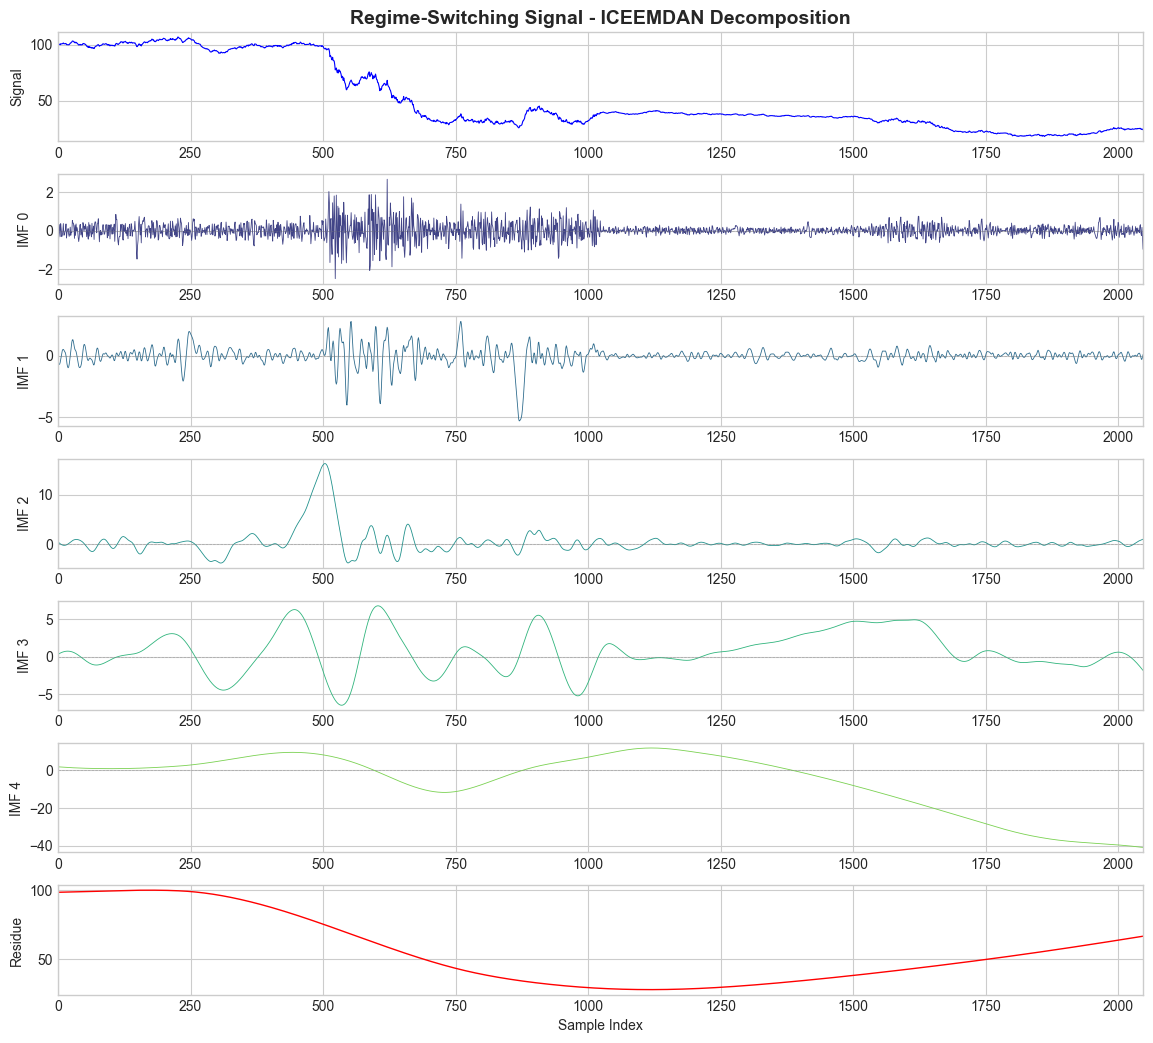

In [14]:
data = datasets['regime']

fig = plot_decomposition(data['signal'], data['imfs'],
                         title="Regime-Switching Signal - ICEEMDAN Decomposition")
plt.show()

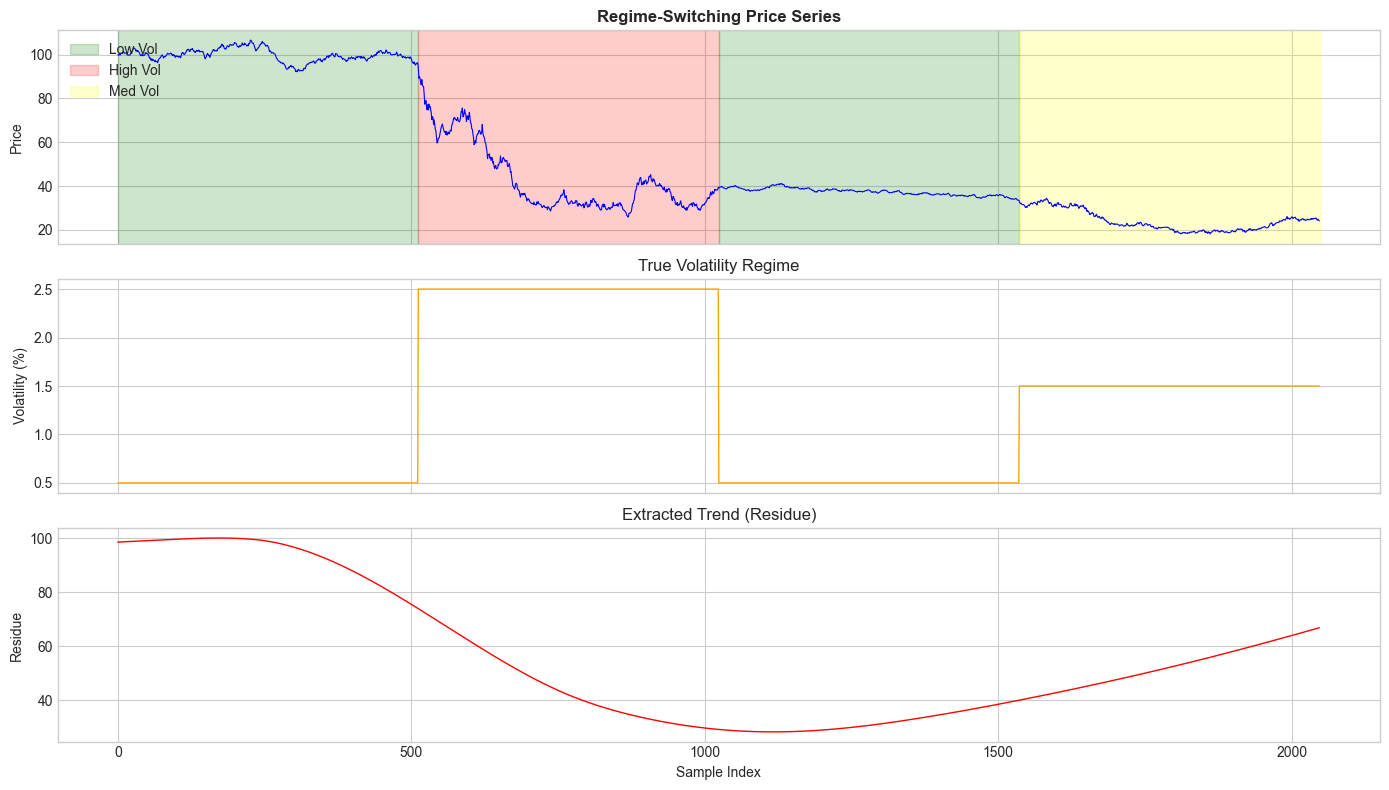

In [15]:
# Show regimes
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

x = data['signal']['index']
n = len(x)

# Price with regime shading
axes[0].plot(x, data['signal']['price'], 'b-', linewidth=0.8)
axes[0].axvspan(0, n//4, alpha=0.2, color='green', label='Low Vol')
axes[0].axvspan(n//4, n//2, alpha=0.2, color='red', label='High Vol')
axes[0].axvspan(n//2, 3*n//4, alpha=0.2, color='green')
axes[0].axvspan(3*n//4, n, alpha=0.2, color='yellow', label='Med Vol')
axes[0].set_ylabel('Price')
axes[0].set_title('Regime-Switching Price Series', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')

# True volatility
axes[1].plot(x, data['signal']['volatility'] * 100, 'orange', linewidth=1)
axes[1].set_ylabel('Volatility (%)')
axes[1].set_title('True Volatility Regime')

# Residue (trend)
axes[2].plot(x, data['imfs']['residue'], 'r-', linewidth=1)
axes[2].set_ylabel('Residue')
axes[2].set_xlabel('Sample Index')
axes[2].set_title('Extracted Trend (Residue)')

plt.tight_layout()
plt.show()

In [16]:
fig = plot_energy_distribution(data['stats'],
                               title="Regime-Switching - Energy Distribution")
plt.show()

### 5.1 Hilbert Analysis - Regime Switching

In [17]:
# Hilbert spectrum shows regime transitions
fig = plot_hilbert_spectrum(data['imfs'], 
                            title="Regime-Switching - Hilbert Spectrum")
plt.show()

In [18]:
# Instantaneous frequency - should show changes at regime boundaries
fig = plot_instantaneous_freq_amp(data['imfs'], max_imfs=4,
                                   title="Regime-Switching - Instantaneous Analysis")
plt.show()

## 6. Multi-Scale Synthetic Signal (Clear Separation)

In [19]:
data = datasets['multiscale']

fig = plot_decomposition(data['signal'], data['imfs'],
                         title="Multi-Scale Signal - ICEEMDAN Decomposition")
plt.show()

In [20]:
# Frequency analysis
fig = plot_frequency_analysis(data['imfs'],
                              title="Multi-Scale - Frequency Content per IMF")
plt.show()

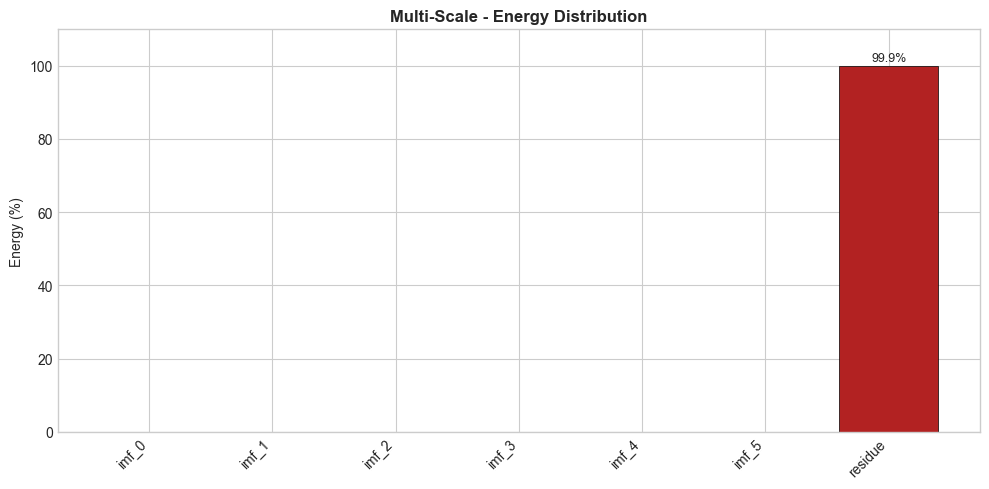

In [21]:
fig = plot_energy_distribution(data['stats'],
                               title="Multi-Scale - Energy Distribution")
plt.show()

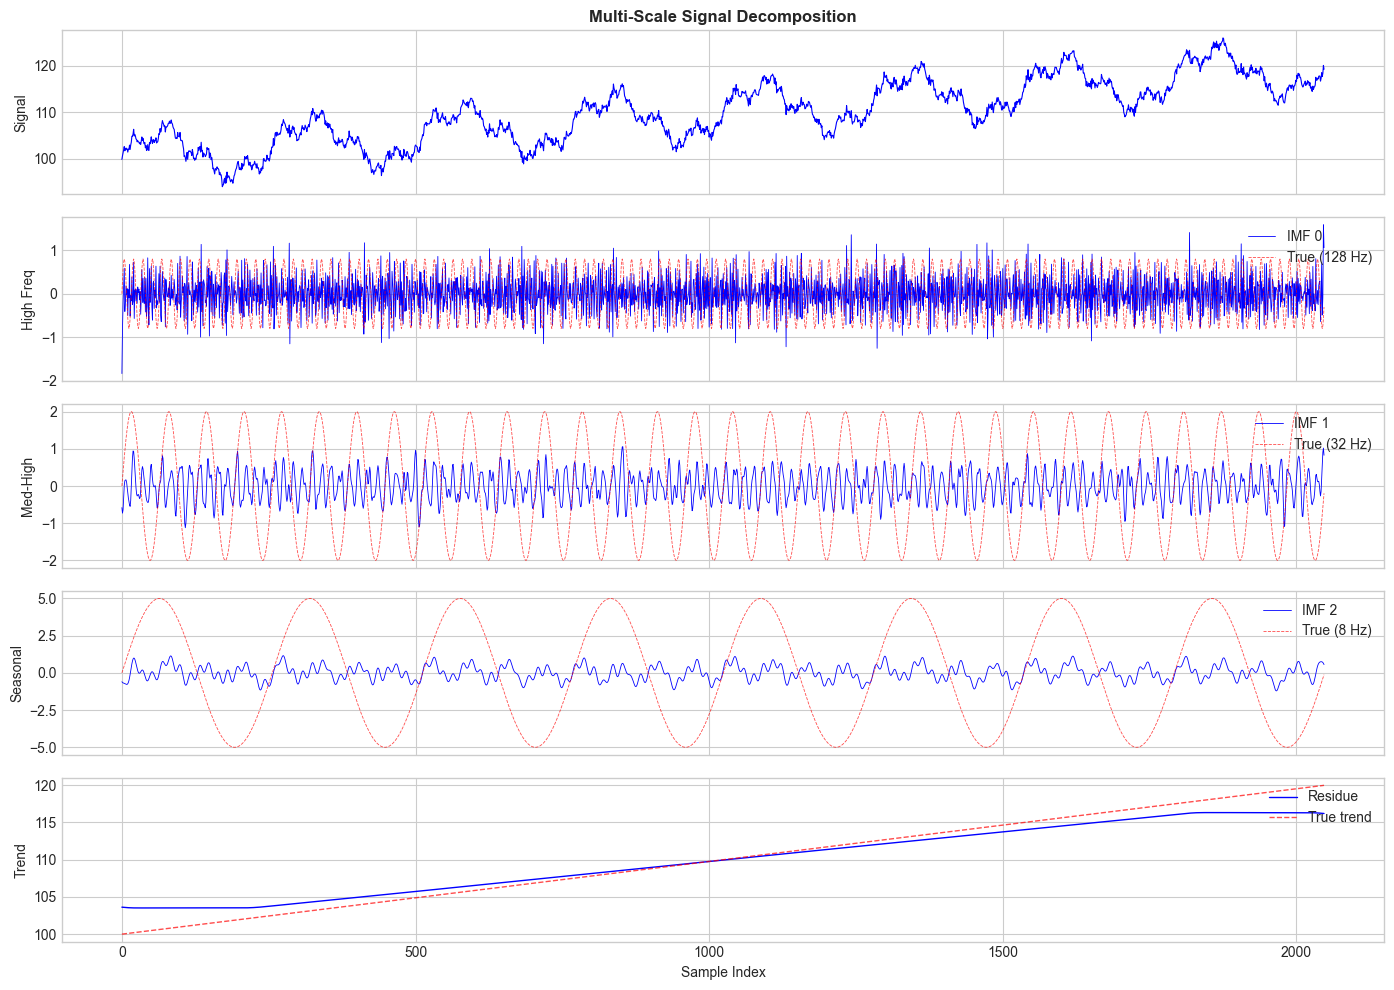

In [22]:
# Show the known components vs extracted IMFs
fig, axes = plt.subplots(5, 1, figsize=(14, 10), sharex=True)

x = data['imfs']['index'].values
n = len(x)
t = x / n

# Original signal
axes[0].plot(x, data['signal']['price'], 'b-', linewidth=0.8)
axes[0].set_ylabel('Signal')
axes[0].set_title('Multi-Scale Signal Decomposition', fontsize=12, fontweight='bold')

# Known: High freq (128 cycles)
known_high = 0.8 * np.sin(2 * np.pi * 128 * t)
axes[1].plot(x, data['imfs']['imf_0'], 'b-', linewidth=0.6, label='IMF 0')
axes[1].plot(x, known_high, 'r--', linewidth=0.6, alpha=0.7, label='True (128 Hz)')
axes[1].set_ylabel('High Freq')
axes[1].legend(loc='upper right')

# Known: Med-high freq (32 cycles)
known_medhigh = 2.0 * np.sin(2 * np.pi * 32 * t)
axes[2].plot(x, data['imfs']['imf_1'], 'b-', linewidth=0.6, label='IMF 1')
axes[2].plot(x, known_medhigh, 'r--', linewidth=0.6, alpha=0.7, label='True (32 Hz)')
axes[2].set_ylabel('Med-High')
axes[2].legend(loc='upper right')

# Known: Seasonal (8 cycles)
known_seasonal = 5.0 * np.sin(2 * np.pi * 8 * t)
axes[3].plot(x, data['imfs']['imf_2'], 'b-', linewidth=0.6, label='IMF 2')
axes[3].plot(x, known_seasonal, 'r--', linewidth=0.6, alpha=0.7, label='True (8 Hz)')
axes[3].set_ylabel('Seasonal')
axes[3].legend(loc='upper right')

# Known: Trend
known_trend = 100.0 + 20.0 * t
axes[4].plot(x, data['imfs']['residue'], 'b-', linewidth=1, label='Residue')
axes[4].plot(x, known_trend, 'r--', linewidth=1, alpha=0.7, label='True trend')
axes[4].set_ylabel('Trend')
axes[4].set_xlabel('Sample Index')
axes[4].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 6.1 Hilbert Analysis - Multi-Scale

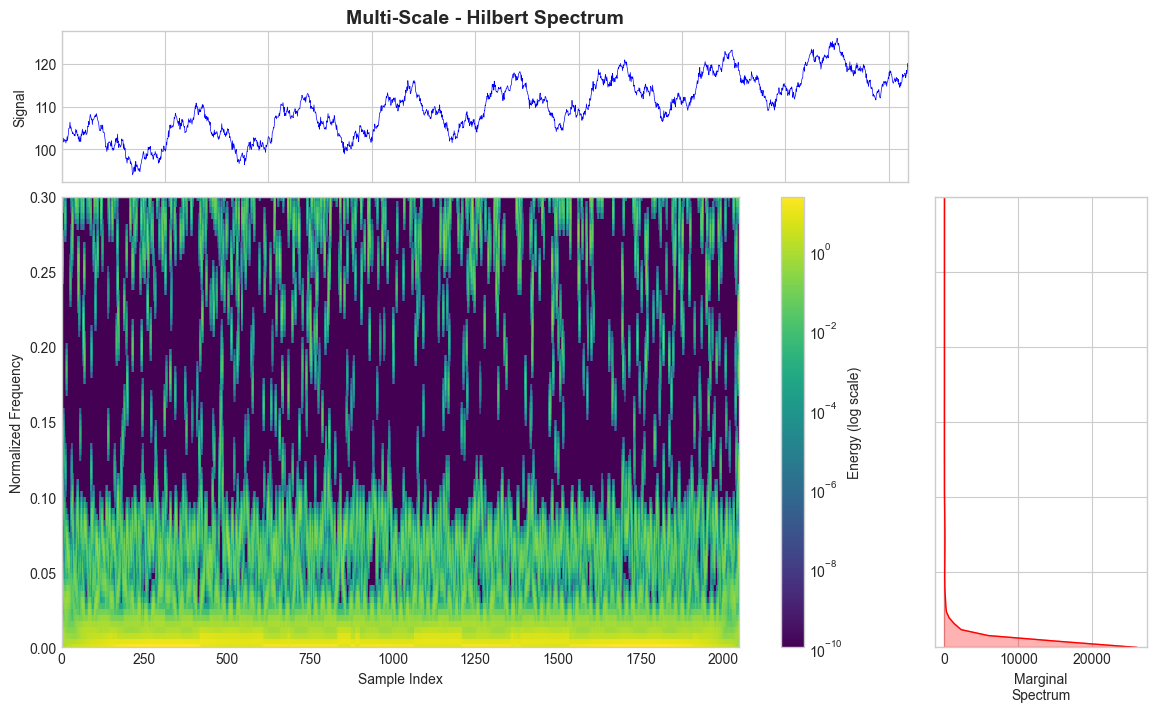

In [23]:
# Hilbert spectrum - should show distinct frequency bands
fig = plot_hilbert_spectrum(data['imfs'], 
                            title="Multi-Scale - Hilbert Spectrum")
plt.show()

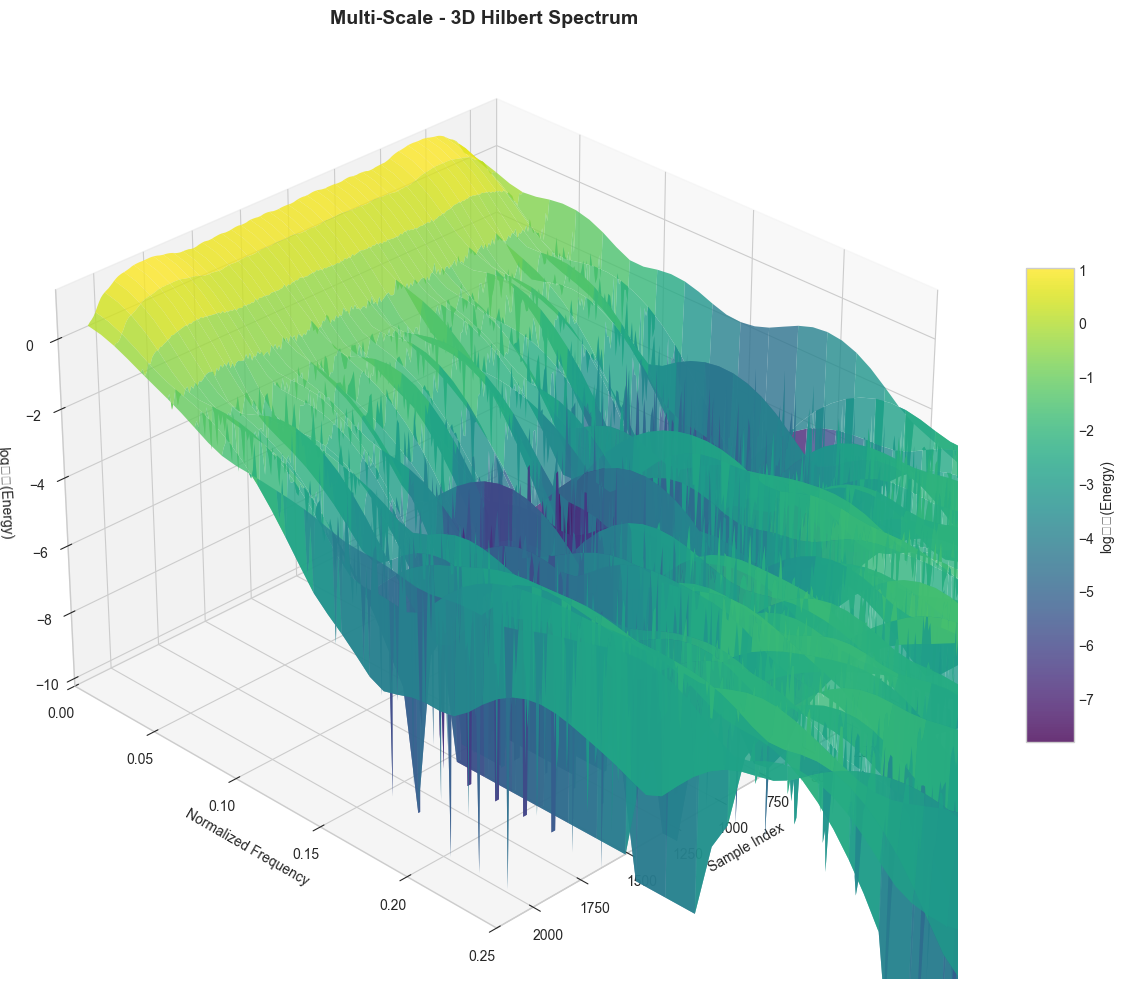

In [24]:
# 3D view
fig = plot_hilbert_spectrum_3d(data['imfs'],
                                title="Multi-Scale - 3D Hilbert Spectrum")
plt.show()

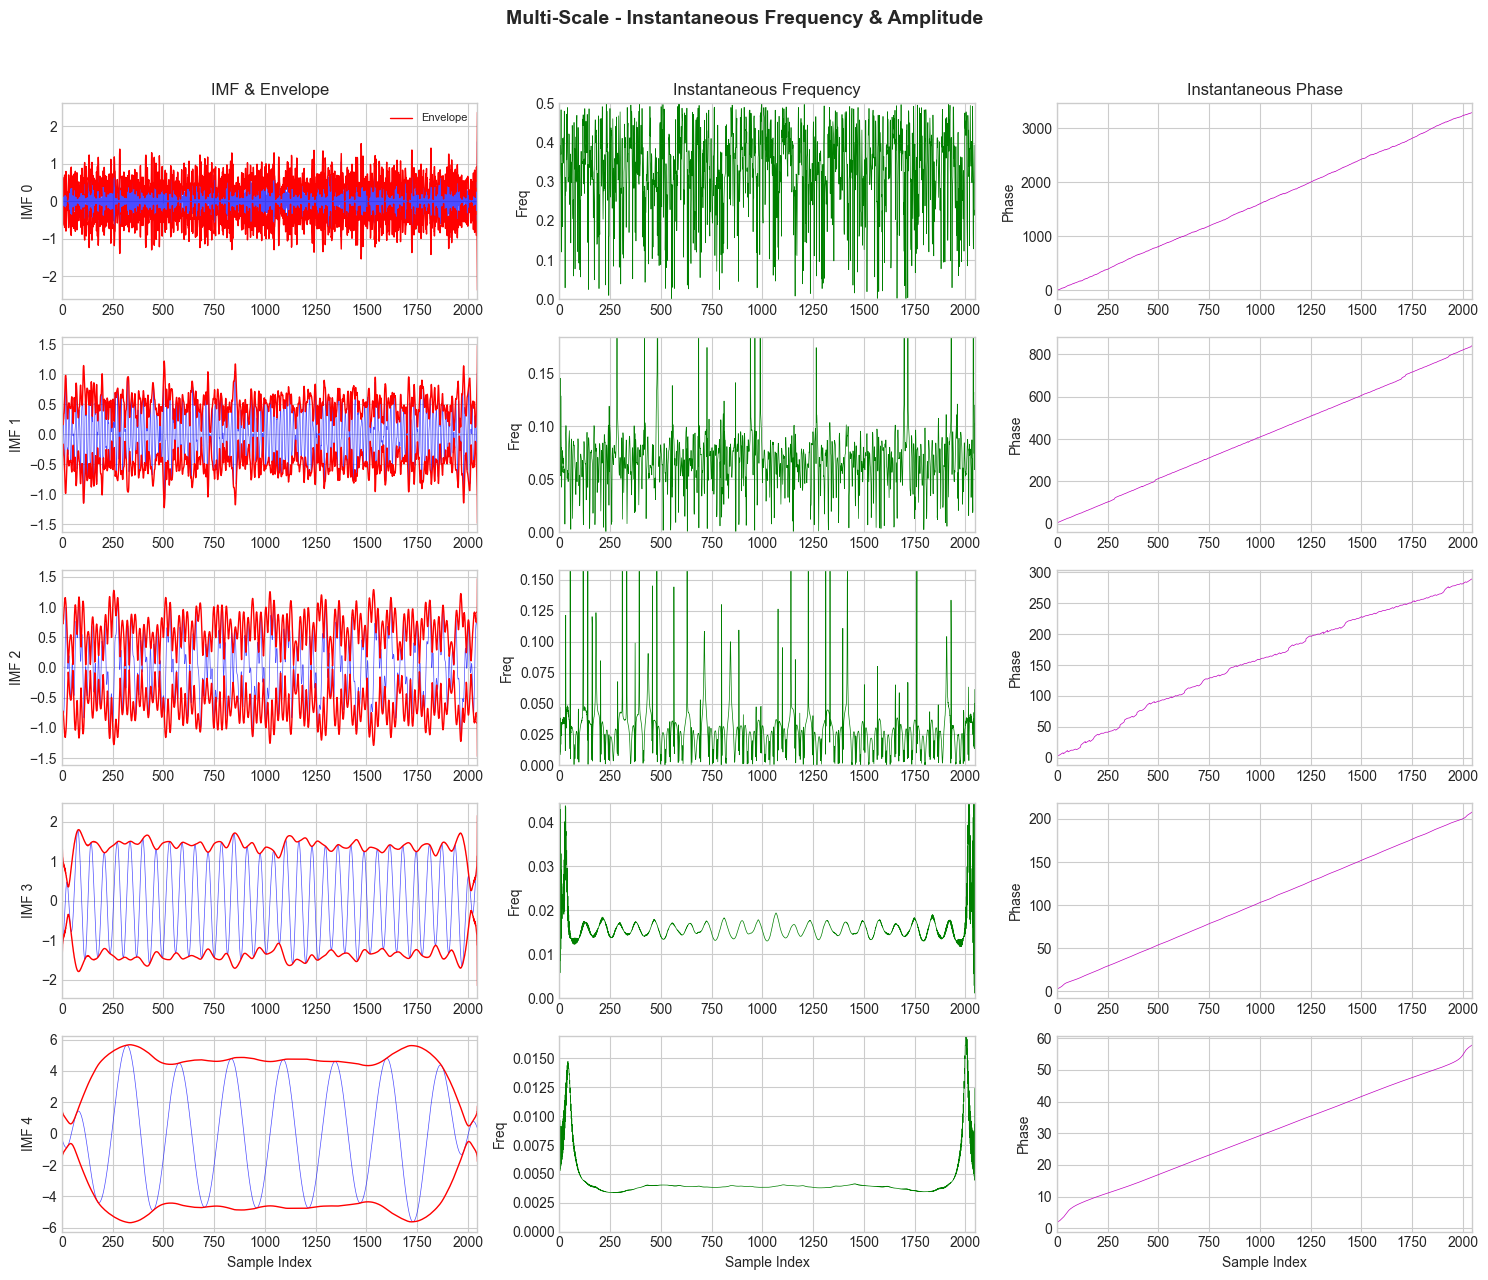

In [25]:
# Instantaneous frequency - should show constant frequencies for pure sinusoids
fig = plot_instantaneous_freq_amp(data['imfs'], max_imfs=5,
                                   title="Multi-Scale - Instantaneous Frequency & Amplitude")
plt.show()

## 7. IMF Statistics Summary

In [26]:
# Compare stats across datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, name in enumerate(['garch', 'regime', 'multiscale']):
    stats = datasets[name]['stats']
    
    ax = axes[idx]
    labels = stats['imf']
    energy = stats['energy_pct']
    
    colors = ['steelblue'] * (len(labels) - 1) + ['firebrick']
    ax.bar(range(len(labels)), energy, color=colors, edgecolor='black', linewidth=0.5)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Energy (%)')
    ax.set_title(f'{name.upper()}', fontsize=11, fontweight='bold')

plt.suptitle('Energy Distribution Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [27]:
# Print summary table
print("\n" + "="*60)
print("DECOMPOSITION SUMMARY")
print("="*60)

for name in ['garch', 'regime', 'multiscale']:
    diag = datasets[name]['diag']
    stats = datasets[name]['stats']
    
    diag_dict = dict(zip(diag['metric'], diag['value']))
    
    print(f"\n{name.upper()}:")
    print(f"  Signal length:       {int(float(diag_dict['signal_length']))}")
    print(f"  IMFs extracted:      {int(float(diag_dict['num_imfs']))}")
    print(f"  Computation time:    {float(diag_dict['elapsed_ms']):.1f} ms")
    print(f"  Orthogonality index: {float(diag_dict['orthogonality_index']):.4f}")
    print(f"  Residue energy:      {stats[stats['imf']=='residue']['energy_pct'].values[0]:.1f}%")


DECOMPOSITION SUMMARY

GARCH:
  Signal length:       2048
  IMFs extracted:      8
  Computation time:    37.0 ms
  Orthogonality index: 0.6332
  Residue energy:      97.6%

REGIME:
  Signal length:       2048
  IMFs extracted:      5
  Computation time:    14.6 ms
  Orthogonality index: 0.0260
  Residue energy:      92.9%

MULTISCALE:
  Signal length:       2048
  IMFs extracted:      6
  Computation time:    14.6 ms
  Orthogonality index: 0.0998
  Residue energy:      99.9%


## 8. Trading Application: Detrending & Filtering

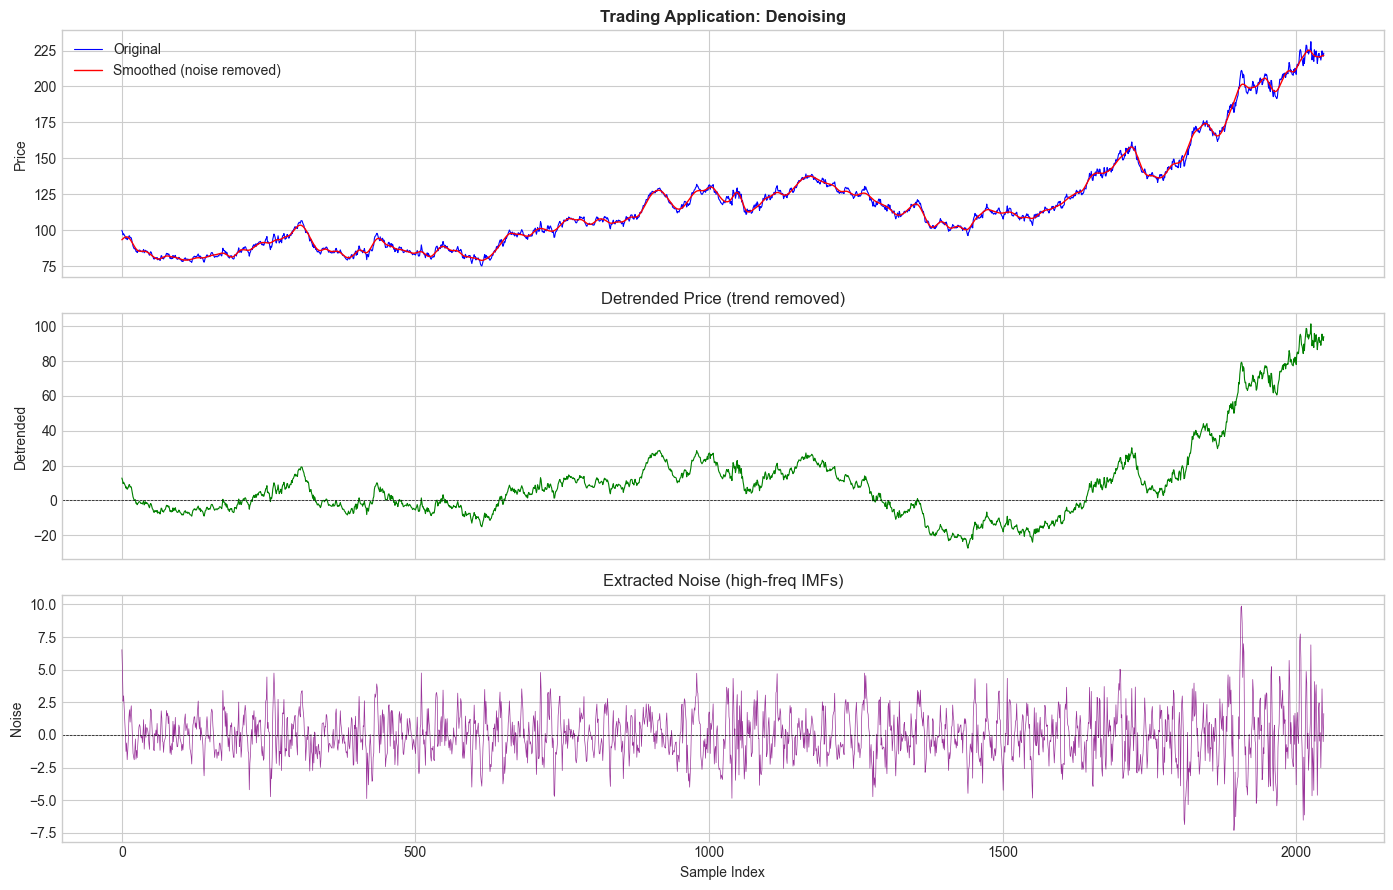

In [28]:
# Use GARCH data for trading example
data = datasets['garch']
imfs = data['imfs']
signal = data['signal']

# Detrended price = price - residue
detrended = signal['price'].values - imfs['residue'].values

# High-freq noise (IMF 0-1)
imf_cols = [c for c in imfs.columns if c.startswith('imf_')]
noise = imfs[imf_cols[0]].values + imfs[imf_cols[1]].values if len(imf_cols) > 1 else imfs[imf_cols[0]].values

# Smoothed price = price - noise
smoothed = signal['price'].values - noise

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

x = signal['index']

axes[0].plot(x, signal['price'], 'b-', linewidth=0.8, label='Original')
axes[0].plot(x, smoothed, 'r-', linewidth=1, label='Smoothed (noise removed)')
axes[0].set_ylabel('Price')
axes[0].set_title('Trading Application: Denoising', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper left')

axes[1].plot(x, detrended, 'g-', linewidth=0.8)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[1].set_ylabel('Detrended')
axes[1].set_title('Detrended Price (trend removed)')

axes[2].plot(x, noise, 'purple', linewidth=0.5, alpha=0.8)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[2].set_ylabel('Noise')
axes[2].set_xlabel('Sample Index')
axes[2].set_title('Extracted Noise (high-freq IMFs)')

plt.tight_layout()
plt.show()

## 9. Hilbert Spectrum Comparison

Compare the time-frequency characteristics of different signal types.

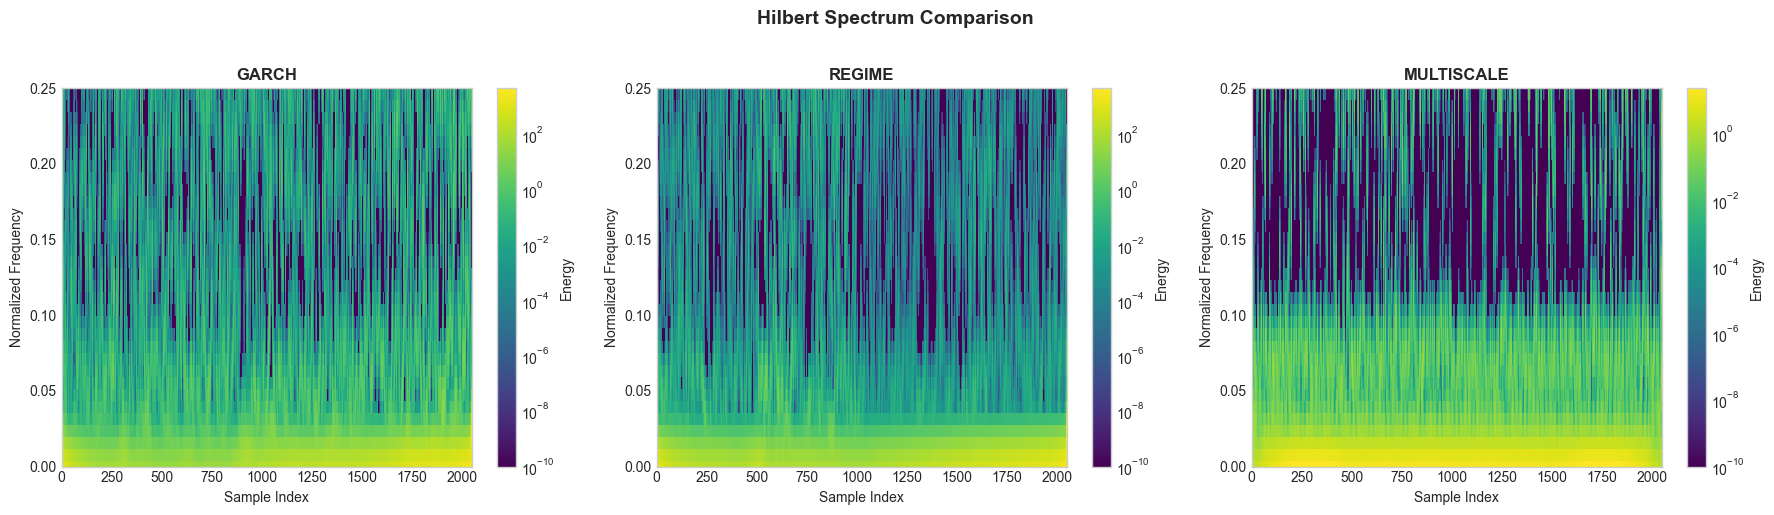

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, name in enumerate(['garch', 'regime', 'multiscale']):
    imfs_df = datasets[name]['imfs']
    spectrum, time_axis, freq_axis = compute_hilbert_spectrum(imfs_df, freq_bins=64)
    
    spectrum_plot = spectrum.T
    spectrum_plot[spectrum_plot < 1e-10] = 1e-10
    
    im = axes[idx].pcolormesh(time_axis, freq_axis, spectrum_plot,
                              norm=LogNorm(vmin=spectrum_plot[spectrum_plot > 0].min(),
                                          vmax=spectrum_plot.max()),
                              cmap='viridis', shading='auto')
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('Normalized Frequency')
    axes[idx].set_title(f'{name.upper()}', fontsize=12, fontweight='bold')
    axes[idx].set_ylim([0, 0.25])
    plt.colorbar(im, ax=axes[idx], label='Energy')

plt.suptitle('Hilbert Spectrum Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [30]:
# Marginal spectrum comparison
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['blue', 'orange', 'green']
for idx, name in enumerate(['garch', 'regime', 'multiscale']):
    imfs_df = datasets[name]['imfs']
    spectrum, time_axis, freq_axis = compute_hilbert_spectrum(imfs_df, freq_bins=128)
    marginal = compute_marginal_spectrum(spectrum, freq_axis)
    
    # Normalize for comparison
    marginal = marginal / marginal.max()
    
    ax.plot(freq_axis, marginal, color=colors[idx], linewidth=1.5, label=name.upper())

ax.set_xlabel('Normalized Frequency')
ax.set_ylabel('Normalized Marginal Spectrum')
ax.set_title('Marginal Hilbert Spectrum Comparison', fontsize=12, fontweight='bold')
ax.set_xlim([0, 0.2])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Mean Frequency per IMF

In [31]:
def compute_mean_freq_per_imf(imfs_df):
    """
    Compute weighted mean instantaneous frequency for each IMF.
    """
    imf_cols = [c for c in imfs_df.columns if c.startswith('imf_')]
    results = []
    
    for col in imf_cols:
        imf = imfs_df[col].values
        inst_freq, inst_amp, _ = compute_instantaneous_freq_amp(imf)
        
        # Weighted mean frequency (weighted by amplitude)
        weights = inst_amp ** 2
        weighted_freq = np.sum(inst_freq * weights) / np.sum(weights)
        
        # Also get median (more robust)
        median_freq = np.median(inst_freq)
        
        results.append({
            'imf': col,
            'mean_freq': weighted_freq,
            'median_freq': median_freq,
            'std_freq': np.std(inst_freq),
            'mean_amp': np.mean(inst_amp)
        })
    
    return pd.DataFrame(results)

# Compute for all datasets
print("\nMean Frequency per IMF:")
print("="*70)

for name in ['garch', 'regime', 'multiscale']:
    freq_df = compute_mean_freq_per_imf(datasets[name]['imfs'])
    print(f"\n{name.upper()}:")
    print(freq_df.to_string(index=False))


Mean Frequency per IMF:

GARCH:
  imf  mean_freq  median_freq  std_freq  mean_amp
imf_0   0.240318     0.257046  0.115963  1.216559
imf_1   0.056291     0.061356  0.043921  1.634095
imf_2   0.013502     0.015933  0.016918  3.361659
imf_3   0.004058     0.003897  0.004141  7.208117
imf_4   0.001961     0.001098  0.002136 11.257253
imf_5   0.001556     0.000981  0.001226  7.396861
imf_6   0.001029     0.000814  0.001349  4.966983
imf_7   0.000769     0.000165  0.002178  8.038644

REGIME:
  imf  mean_freq  median_freq  std_freq  mean_amp
imf_0   0.248471     0.250632  0.120201  0.410397
imf_1   0.042845     0.055753  0.049812  0.656712
imf_2   0.006777     0.014423  0.016514  1.905585
imf_3   0.004243     0.003934  0.004552  3.351180
imf_4   0.001125     0.000769  0.000962 19.304027

MULTISCALE:
  imf  mean_freq  median_freq  std_freq  mean_amp
imf_0   0.338682     0.342040  0.100380  0.510614
imf_1   0.072128     0.069956  0.032477  0.519874
imf_2   0.026479     0.027750  0.030828  0.65

In [32]:
# Visualize mean frequency decay
fig, ax = plt.subplots(figsize=(10, 6))

markers = ['o', 's', '^']
colors = ['blue', 'orange', 'green']

for idx, name in enumerate(['garch', 'regime', 'multiscale']):
    freq_df = compute_mean_freq_per_imf(datasets[name]['imfs'])
    imf_idx = range(len(freq_df))
    
    ax.semilogy(imf_idx, freq_df['mean_freq'], 
                marker=markers[idx], color=colors[idx], 
                linewidth=2, markersize=8, label=name.upper())

ax.set_xlabel('IMF Index')
ax.set_ylabel('Mean Frequency (log scale)')
ax.set_title('Frequency Decay Across IMFs', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(max(len(compute_mean_freq_per_imf(datasets[n]['imfs'])) for n in datasets)))

plt.tight_layout()
plt.show()

print("\nNote: IMFs are ordered from high to low frequency.")
print("The exponential decay confirms proper multi-scale separation.")


Note: IMFs are ordered from high to low frequency.
The exponential decay confirms proper multi-scale separation.


In [33]:
print("\nNotebook complete!")
print("\nKey takeaways:")
print("- ICEEMDAN cleanly separates multi-scale components")
print("- Residue captures the underlying trend")
print("- High-frequency IMFs capture noise and microstructure")
print("- Perfect reconstruction: sum(IMFs) + residue = original signal")
print("- Hilbert spectrum reveals time-varying frequency content")
print("- Instantaneous frequency shows oscillation patterns within each IMF")
print("- IMF frequencies decrease exponentially (dyadic filterbank-like behavior)")


Notebook complete!

Key takeaways:
- ICEEMDAN cleanly separates multi-scale components
- Residue captures the underlying trend
- High-frequency IMFs capture noise and microstructure
- Perfect reconstruction: sum(IMFs) + residue = original signal
- Hilbert spectrum reveals time-varying frequency content
- Instantaneous frequency shows oscillation patterns within each IMF
- IMF frequencies decrease exponentially (dyadic filterbank-like behavior)
